<a href="https://colab.research.google.com/github/voquangtuong/DL_Tutorial/blob/master/Multi_channel_CNN_Multivariate_out_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. CONNECT GGD

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os
os.chdir('/content/drive/MyDrive')
out_dirs=['out_figs_CNN','out_tabs_CNN']
for out_dir in out_dirs:
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

# 2. BASIC LIBRARIES AND FUNCTIONS

## 2.1 LIBRARIES

In [33]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## 2.1 CONVERT HISTORY INTO INPUTS AND OUTPUTS

In [34]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=6):
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end < len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
  # move along one time step
  in_start += 1
  return np.array(X), np.array(y)

## 2.2 FORCASTING FUNCTIONS

In [35]:
# make a forecast
def forecast(model, history, n_input):
  # flatten data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0] # ORG bo di de lay het gia tri cua cac channel

  return yhat

## 2.3 EVALUATE FORECAST FUNCTIONS

In [36]:
def evaluate_forecasts(actual,predicted):
  scores=list()
  for i in range(actual.shape[1]):
    mse=mean_squared_error(actual[:,i],predicted[:,i])
    rmse=sqrt(mse)
    scores.append(rmse)
  # calculate overall RMSE
  s=0
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s+=(actual[row,col]-predicted[row,col])**2
  score=sqrt(s/(actual.shape[0]*actual.shape[1]))
  return score, scores
  # score: sai so trung binh toan bo
  # scores: sai so cua tung buoc

## 2.3 EVALUATE MODEL FUNCTIONS

In [37]:
# evaluate a single model
def evaluate_model(train, test, n_input):
# fit model
  model = build_model(train, n_input)
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = np.array(predictions)
  score, scores = evaluate_forecasts(test[:, :, 0], predictions)
  return score, scores

## 2.4 TRAINING N INPUT N OUTPUT FUNCTIONS

In [38]:
# train the model
def build_model(train, n_input):
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # define parameters
  verbose, epochs, batch_size = 0, 70, 16
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # define model
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu',
    input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model

## 2.5 SPLIT DATA SET FUNCTIONS

In [39]:
def split_dataset(data,train_test_ratio,n_output_steps):
  # split into standard weeks
  # boi so cua buoc
  n_pairs_totall=int(data.shape[0]/n_output_steps)
  n_pairs_train=int(train_test_ratio*int(data.shape[0]/n_output_steps))
  n_pairs_test=int(n_pairs_totall-n_pairs_train)
  train, test = data[:-(n_pairs_train*n_output_steps)], data[-(n_pairs_train*n_output_steps):-n_output_steps]
  # restructure into windows of number_steps data
  train = np.array(np.split(train, train.shape[0]/n_output_steps))
  test = np.array(np.split(test, test.shape[0]/n_output_steps))
  return train, test

## 2.6 SUMMARIZE SCORE FUNCTIONS

In [40]:
# summarize scores
def summarize_scores(name, score, scores):
  s_scores=','.join(['%.1f' % s for s in scores])
  print('%s: [%.3f] %s' %(name, score,s_scores))

# 3 DATA PROCESSING

## 3.1 LOAD DATA

In [41]:
# load the new file
dataset = pd.read_csv('input_data/percentile_101.csv', header=0,
infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])

## 3.2 SPLIT DATASET

In [42]:
# split into train and test
train, test = split_dataset(dataset.values,train_test_ratio=0.23,n_output_steps=6)

## 3.3 SET INPUT LAG

In [43]:
n_input = 12 # 24 thang tot nhat cho cnn

## 3.4 EVALUATE MODELS

In [44]:
score, scores = evaluate_model(train, test, n_input)

## 3.5 SUMMARIZE AND PLOT

cnn: [0.606] 0.7,0.6,0.6,0.6,0.7,0.3


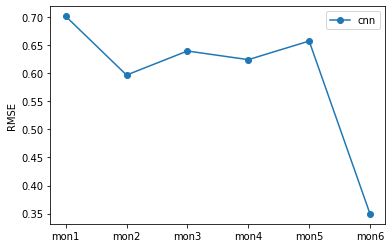

In [45]:
summarize_scores('cnn', score, scores)
# plot scores
days = ['mon1', 'mon2', 'mon3', 'mon4', 'mon5', 'mon6']
plt.plot(days, scores, marker='o', label='cnn')
plt.legend()
plt.ylabel('RMSE')
plt.show()

# 4. FARMING

## 4.1 MULTI-VARIATES OUTPUT 

In [46]:
model=build_model(train, n_input)

In [48]:
# prepare testing data
test_x, test_y = to_supervised(test, n_input)
yhat=model.predict(test_x)
yhat

array([[-0.09442836, -0.20518884, -0.07032948, -0.04716875,  0.15378803,
         0.3636788 ],
       [-0.09442836, -0.20518884, -0.07032948, -0.04716875,  0.15378803,
         0.3636788 ],
       [-0.09442836, -0.20518884, -0.07032948, -0.04716875,  0.15378803,
         0.3636788 ],
       [-0.09442836, -0.20518884, -0.07032948, -0.04716875,  0.15378803,
         0.3636788 ],
       [-0.09442836, -0.20518884, -0.07032948, -0.04716875,  0.15378803,
         0.3636788 ],
       [-0.09442836, -0.20518884, -0.07032948, -0.04716875,  0.15378803,
         0.3636788 ],
       [-0.09442836, -0.20518884, -0.07032948, -0.04716875,  0.15378803,
         0.3636788 ],
       [-0.09442836, -0.20518884, -0.07032948, -0.04716875,  0.15378803,
         0.3636788 ],
       [-0.09442836, -0.20518884, -0.07032948, -0.04716875,  0.15378803,
         0.3636788 ],
       [-0.09442836, -0.20518884, -0.07032948, -0.04716875,  0.15378803,
         0.3636788 ],
       [-0.09442836, -0.20518884, -0.07032948, -0.